In [9]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import os
from shapely.geometry import Point
import ast  
import matplotlib.patches as mpatches

#path = "/Users/claireconzelmann/Documents/KIHC-affordable-housing-analysis"
path = "/Users/aliso/OneDrive/Documents/KIHC-affordable-housing-analysis"

In [16]:
tif_districts = pd.read_csv(os.path.join(path, "Data/Raw/Boundaries_Tax_Increment_Financing_Districts.csv"))
city_land = pd.read_csv(os.path.join(path, "Data/Raw/City-Owned_Land_Inventory_20250320.csv"))
l_stops = pd.read_csv(os.path.join(path, "Data/Raw/CTA_System_Information_List_of_L_Stops.csv"))
vacant_buildings = pd.read_csv(os.path.join(path, "Data/Raw/311_Service_Requests_20250321.csv"))
bus_stops_gdf = gpd.read_file(os.path.join(path, "Data/Raw/CTA_BusStops.shp"))
metra_stops_gdf = gpd.read_file(os.path.join(path, "Data/Raw/MetraStations.shp"))
foreclosed_rentals  = pd.read_csv(os.path.join(path, "Data/Raw/Foreclosed_Rental_Property_20250324.csv"))

C:\Users\aliso\AppData\Local\Temp\ipykernel_9684\374191695.py:4: DtypeWarning: Columns (20,30) have mixed types. Specify dtype option on import or set low_memory=False.
  vacant_buildings = pd.read_csv(os.path.join(path, "Data/Raw/311_Service_Requests_20250321.csv"))


In [11]:
#create geopandas objects
tif_districts["the_geom"] = tif_districts["the_geom"].apply(wkt.loads)
tif_districts_gdf = gpd.GeoDataFrame(tif_districts, geometry="the_geom")
tif_districts_gdf = tif_districts_gdf.set_crs(epsg=4326, inplace=True)

city_land_gpd = gpd.GeoDataFrame(city_land, 
                                 geometry=gpd.points_from_xy(city_land.Longitude, 
                                                             city_land.Latitude), 
                                 crs="EPSG:4326")

# Convert string representation of tuples of long/lat in lstop data into actual tuples
l_stops["Location"] = l_stops["Location"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

l_stops["geometry"] = l_stops["Location"].apply(lambda x: Point(x[1], x[0]))
l_stops_gdf = gpd.GeoDataFrame(l_stops, geometry="geometry")
l_stops_gdf.set_crs(epsg=4326, inplace=True)

bus_stops_gdf.set_crs(epsg=4326, inplace=True)
metra_stops_gdf.to_crs(epsg=4326, inplace=True)


In [12]:
#filtering metra stops to chicago only
metra_stops_gdf = metra_stops_gdf.loc[metra_stops_gdf["MUNICIPALI"]=="Chicago"]

#create 1/2 mile buffers around CTA and Metra stops (ETOD eligible)
metra_stops_gdf = metra_stops_gdf.to_crs(epsg=3857)
metra_stops_gdf["buffer_half_mile"] = metra_stops_gdf.geometry.buffer(804.67)
metra_stops_gdf = metra_stops_gdf.to_crs(epsg=4326)

l_stops_gdf = l_stops_gdf.to_crs(epsg=3857)
l_stops_gdf["buffer_half_mile"] = l_stops_gdf.geometry.buffer(804.67)
l_stops_gdf = l_stops_gdf.to_crs(epsg=4326)

In [13]:
#find vacant city owned lots within 1/2 buffers of transit stations
etod_lots_l = gpd.sjoin(city_land_gpd, 
                        l_stops_gdf.set_geometry("buffer_half_mile").to_crs(epsg=4326), 
                        predicate="within")

etod_lots_metra = gpd.sjoin(city_land_gpd, 
                        metra_stops_gdf.set_geometry("buffer_half_mile").to_crs(epsg=4326), 
                        predicate="within")

etod_lots = pd.concat([etod_lots_l, etod_lots_metra], ignore_index=True).drop_duplicates(subset=["ID"])
etod_lots = etod_lots.drop("index_right", axis=1)


In [14]:
#find etod eligible lots that are within existing TIFs
etod_lots_tifs = gpd.sjoin(etod_lots, 
                        tif_districts_gdf, 
                        predicate="within")
etod_lots_tifs = etod_lots_tifs.drop_duplicates(subset=["ID"])

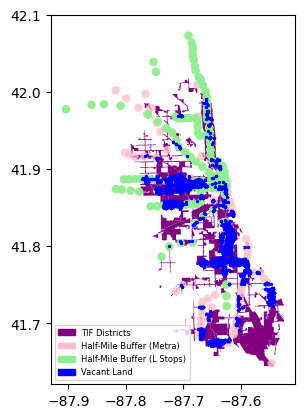

In [ ]:
#plot everything together
fig, ax = plt.subplots()
tif_districts_gdf.plot(ax=ax, 
                       color='purple',
                       label="TIF districts")
metra_stops_gdf.set_geometry("buffer_half_mile").to_crs(epsg=4326).plot(ax=ax, 
                                                                        color="pink", 
                                                                        alpha=0.8, 
                                                                        label="Half-Mile Buffer")
l_stops_gdf.set_geometry("buffer_half_mile").to_crs(epsg=4326).plot(ax=ax, 
                                                                    color="lightgreen", 
                                                                    alpha=0.8, 
                                                                    label="Half-Mile Buffer")
etod_lots_tifs.plot(ax=ax, 
                    color='blue', 
                    markersize=2,
                    label="vacant land")

legend_patches = [
    mpatches.Patch(color='purple', label="TIF Districts"),
    mpatches.Patch(color='pink', label="Half-Mile Buffer (Metra)"),
    mpatches.Patch(color='lightgreen', label="Half-Mile Buffer (L Stops)"),
    mpatches.Patch(color='blue', label="Vacant Land")
]

ax.legend(handles=legend_patches, loc="lower left", fontsize=6)

In [ ]:

#filtering vacant buildings to within the past year
vacant_buildings = vacant_buildings.loc[vacant_buildings["DUPLICATE"]==False]
start_date = '2024-10-21'
end_date = '2025-03-21'
vacant_buildings['CREATED_DATE'] = pd.to_datetime(vacant_buildings['CREATED_DATE'], format='%m/%d/%Y %I:%M:%S %p')
vacant_buildings_recent = vacant_buildings[(vacant_buildings['CREATED_DATE'] >= start_date) & (vacant_buildings['CREATED_DATE'] <= end_date)]


foreclosed_rentals['SUBMISSION DATE'] = pd.to_datetime(foreclosed_rentals['SUBMISSION DATE'], format='%m/%d/%Y')
foreclosed_rentals_recent = foreclosed_rentals[(foreclosed_rentals['SUBMISSION DATE'] >= start_date) & (foreclosed_rentals['SUBMISSION DATE'] <= end_date)]


vacant_buildings_recent_gdf = gpd.GeoDataFrame(vacant_buildings_recent, 
                                 geometry=gpd.points_from_xy(vacant_buildings_recent.LONGITUDE, 
                                                             vacant_buildings_recent.LATITUDE), 
                                 crs="EPSG:4326")


fig, ax = plt.subplots()
vacant_buildings_recent_gdf.plot(ax=ax, 
                    color='blue', 
                    markersize=2,
                    label="vacant buildings")




TypeError: Input must be valid geometry objects: POINT (-87.6453496205995 41.95434471865204)